# Augmentation Pipeline

Augmentation pipeline was redefine as a .py file, available on:

/home/operation/data_synthesis_michel_bt/src/data/augmentation.py

## Step 1 - Import Dependencies

In [2]:
from PIL import Image
import torchvision.transforms as transforms
import os
from PIL import Image
import pandas as pd
import torch
from torch import permute
from torch.utils.data import Dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from class_labels_generator import labels_generator
from labels_generator import generate_csv
from custom_dataset import CustomDataset

/home/operation/miniconda3/envs/ds_bt_1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2 - Augmentation Pipeline

In [ ]:
aug_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomChoice([transforms.RandomRotation((0, 0)), 
                             transforms.RandomRotation((90, 90)), 
                             transforms.RandomRotation((180, 180)), 
                             transforms.RandomRotation((270, 270))]),
    transforms.RandomApply([transforms.ColorJitter(brightness=((0.25, 1.75)))], p=0.75),
    transforms.RandomApply([transforms.ColorJitter(contrast=((0.25, 1.75)))], p=0.75),
    transforms.RandomApply([transforms.ColorJitter(saturation=((0.25, 1.75)))], p=0.75),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))], p=0.25)])

In [1]:
discrete_class = {1 : "0_punching_hole",
                  2 : "1_welding_line",
                  3 : "2_crescent_gap",
                  4 : "3_water_spot",
                  5 : "4_oil_spot",
                  6 : "5_silk_spot",
                  7 : "6_inclusion",
                  8 : "7_rolled_pit",
                  9 : "8_crease",
                  10 : "9_waist_folding"}

In [ ]:
labels_file = []
root_dir = []
datasets = []

for i in range(1,11):
    labels_file.append('../gc10-det/02_raw_train/' + discrete_class[i] + '.csv')
    root_dir.append('../gc10-det/02_raw_train/images/' + discrete_class[i])
    datasets.append(CustomDataset(labels_file=labels_file[i-1], root_dir=root_dir[i-1]))

## Step 3 - Visualizing the Results

In [ ]:
for i in range(0, 10):
    
    index = np.random.randint(datasets[i].__len__())
    image_ori, label = datasets[i].__getitem__(index)

    image_aug = aug_transforms(image_ori)

    fig = plt.figure(figsize=(8, 8))
    fig.add_subplot(1,2,1)
    plt.imshow(image_ori, cmap='gray')
    plt.title(f'{discrete_class[int(label)+1]} - Original')
    
    fig.add_subplot(1,2,2)
    plt.imshow(image_aug, cmap='gray')
    plt.title(f'{discrete_class[int(label)+1]} - Augmented')

## Step 4 - Saving Augmented Images

In [ ]:
def applyAugmentation(dataset, root_path, aug_tranforms, to_tensor, num_instances):
    """Apply augmentation until match a defined number of instances in each class"""
    img_num = 0
    for _ in range(num_instances // dataset.__len__()):
        for image, label in dataset:
            image = aug_tranforms(image)
            image = to_tensor(image)
            if img_num < (num_instances-dataset.__len__()):
                save_image(image, os.path.join(root_path, dataset.__getlabel__(0),'img_augmented_'+str(img_num)+'.jpg'))
                img_num += 1
            else:
                break
    return print('Done!')

In [ ]:
to_tensor = transforms.ToTensor()
root_path = '../gc10-det/03_augmented/1000/images/'
num_instances = 1000

for i in range(10):
    applyAugmentation(datasets[i], root_path, aug_transforms, to_tensor, num_instances)

In [ ]:
augmented_path = '../gc10-det/03_augmented/1000/'

# Saving complete labels
generate_csv(augmented_path)

# Saving class labels
labels_generator(augmented_path)

## Step 5 - Check the Class Distribution

In [3]:
# Reading the .csv labels file
data = pd.read_csv('../gc10-det/03_augmented/1000/labels.csv', header=None)
data.columns = ['Image', 'Class', 'DiscreteClass']
data

,Image,Class,DiscreteClass
0,img_augmented_361.jpg,0_punching_hole,0
1,img_augmented_282.jpg,0_punching_hole,0
2,img_augmented_605.jpg,0_punching_hole,0
3,img_augmented_671.jpg,0_punching_hole,0
4,img_augmented_162.jpg,0_punching_hole,0
...,...,...,...
9995,img_augmented_195.jpg,9_waist_folding,9
9996,img_augmented_30.jpg,9_waist_folding,9
9997,img_augmented_703.jpg,9_waist_folding,9
9998,img_augmented_498.jpg,9_waist_folding,9


<AxesSubplot:title={'center':'Class Distribution'}>

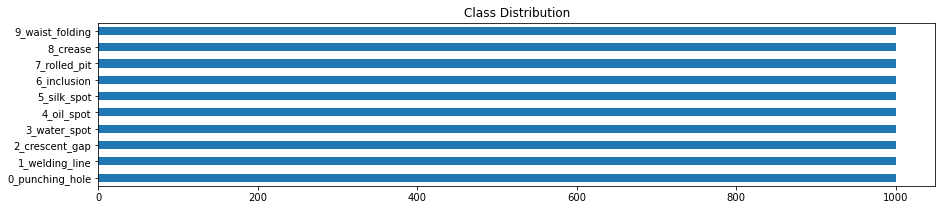

In [4]:
#Checking the Class Distribution
data["Class"].value_counts().plot(kind='barh', title='Class Distribution', figsize=(15,3))